In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Importing the libraries and packages

In [108]:

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import gc
import glob
import pickle
import random
import pandas as pd
import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib.image as matimage
import tensorflow as tf

### Importing datasets

In [68]:
humans_path = "/content/drive/MyDrive/humans_dataset/humans"
no_humans_path = "/content/drive/MyDrive/humans_dataset/no_humans"

humans_no=986
no_humans_no=698

image_list_humans= glob.glob(humans_path + "/*.jpg")
image_list_not_humans = glob.glob(no_humans_path + "/*.jpg")
image_list = image_list_dog[:humans_no] + image_list_cat[:no_humans_no]

labels = list(np.linspace(0,0,humans_no)) + list(np.linspace(1,1,no_humans_no))
#labels = np.asarray(labels, dtype=np.uint8())#[np.uint8(x) for x in labels]

#image_list

Human

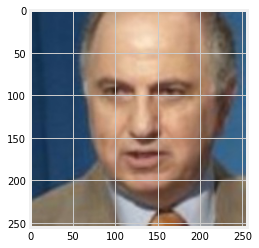

In [70]:
data = matimage.imread(image_list[100])
plt.imshow(data)
plt.show()

Not human

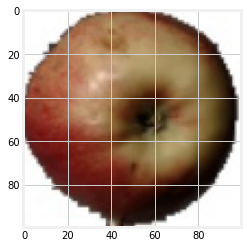

In [71]:
data = matimage.imread(image_list[-102])
plt.imshow(data)
plt.show()

### Get rid of any images that does not have 3 dimensions or 3 in the third dimension (i.e. RGB)

In [72]:
ListToDestroy = []
print(np.shape(image_list))
for i in range(0, len(image_list)):
    if i%500 == 0: print(i)
    try:
        data_x = matimage.imread(image_list[i])
        if len(np.shape(data_x)) != 3:
            ListToDestroy.append(i)
        if np.shape(data_x)[2] != 3:
            ListToDestroy.append(i)
    except:
        ListToDestroy.append(i)
print(ListToDestroy)

(1684,)
0
500
1000
1500
[]


In [74]:
image_list = [i for j, i in enumerate(image_list) if j not in ListToDestroy]
labels = [i for j, i in enumerate(labels) if j not in ListToDestroy]
print(np.shape(image_list),np.shape(labels))

(1684,) (1684,)


### There are functions to do this cropping automatically. But manual has much better flexibility

In [75]:
def aspect_ratio_crop(x, size1, size2):
    if len(np.shape(x)) != 3:
        print("Need 3 dimensions")
    else:
        with tf.device('/cpu:0'):
            short_dim = np.min(np.shape(x)[:2])
            long_dim = np.max(np.shape(x)[:2])
            ## Case 1: height > width
            if np.shape(x)[0]>np.shape(x)[1]:
                #print("Height > Width")
                x = tf.image.crop_to_bounding_box(x,
                                              int((long_dim-short_dim)/2),
                                              0,
                                              short_dim,
                                              short_dim)
            ## Case 2: height < width
            elif np.shape(x)[0]<np.shape(x)[1]:
                #print("Height < Width")
                x = tf.image.crop_to_bounding_box(x,
                                              0,
                                              int((long_dim-short_dim)/2),
                                              short_dim,
                                              short_dim)
            ## Case 3: height = width
            else:
                #print("Height = Width")
                pass

            #if np.min(np.shape(x)[:2]) > np.min([size1, size2]):
            x = tf.image.resize(x, (size1, size2), method='bicubic')
            
            x = (x/np.max(x))#*255
            x = np.array(x)
            #x = x.astype("float16")
            return x

In [76]:
X = []
count = 0
for i in image_list:
    if count%100 == 0: print(count)
    data = matimage.imread(i)
    data = aspect_ratio_crop(data,224,224)
    X.append(data)
    count += 1
X = np.array(X)
print(np.shape(X))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
(1684, 224, 224, 3)


### Test, train split

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X, labels, test_size=0.20, random_state=88)
np.shape(X_train)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

### Building the model

In [80]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### Summary of the model

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 128)     

### Compiling the model

In [82]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [83]:
model.compile(optimizer="adam",
              loss=loss_fn,
              metrics=['accuracy'])

In [84]:
opt = tf.keras.optimizers.Adam(learning_rate=0.005)

### Training the model

In [85]:
bs=64
history = model.fit(X_train, y_train,
                              batch_size=bs,
                              epochs=10,
                              steps_per_epoch=len(X_train)/bs,
                              validation_data=(X_valid, y_valid))

Epoch 1/10
21/21 [==============================] - 143s 7s/step - loss: 0.6379 - accuracy: 0.6904 - val_loss: 1.4879 - val_accuracy: 0.4451
Epoch 2/10
21/21 [==============================] - 130s 6s/step - loss: 0.3261 - accuracy: 0.8768 - val_loss: 0.1279 - val_accuracy: 0.9585
Epoch 3/10
21/21 [==============================] - 146s 7s/step - loss: 0.1069 - accuracy: 0.9644 - val_loss: 0.0748 - val_accuracy: 0.9733
Epoch 4/10
21/21 [==============================] - 145s 7s/step - loss: 0.0627 - accuracy: 0.9770 - val_loss: 0.0579 - val_accuracy: 0.9792
Epoch 5/10
21/21 [==============================] - 133s 6s/step - loss: 0.0494 - accuracy: 0.9866 - val_loss: 0.0436 - val_accuracy: 0.9881
Epoch 6/10
21/21 [==============================] - 130s 6s/step - loss: 0.0358 - accuracy: 0.9896 - val_loss: 0.0338 - val_accuracy: 0.9911
Epoch 7/10
21/21 [==============================] - 130s 6s/step - loss: 0.0161 - accuracy: 0.9926 - val_loss: 0.0536 - val_accuracy: 0.9852
Epoch 8/10
21

### Evaluating the model's accuracy

In [87]:
model.evaluate(X_valid, y_valid)

11/11 [==============================] - 10s 891ms/step - loss: 0.1269 - accuracy: 0.9703


[0.12694396078586578, 0.9703264236450195]

### The model is 97% accurate in prediction

# Making predictions using a random image from test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


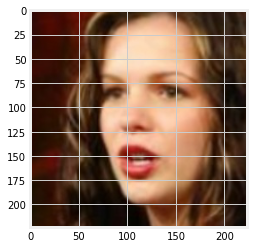

Our model says: Human is present


In [107]:
random_image=random.randint(0,len(y_valid))
plt.imshow(X_valid[random_image, :])
plt.show()

y_pred=model.predict(X_valid[random_image, :].reshape(1,224, 224, 3))
y_pred = y_pred > 0.5

if(y_pred == 0):
  prediction = "Human is present"
else:
  prediction = "human is not present"

print("Our model says:",prediction)